<a href="https://colab.research.google.com/github/poojashreeNS/RA_Twitter_Sentiment_Analysis/blob/main/RA_Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Required libraries
!pip install emoji --upgrade
!pip install gensim --upgrade
!pip install keras --upgrade

In [2]:
#Imports
import numpy as np # Numpy
import pandas as pd # Pandas

from google.colab import data_table # Displaying pagewise table

# String manipulation 
import re
import string

# Emoji decoding
from emoji import demojize

# Visualtion
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
from wordcloud import WordCloud

# NLTK for language processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Min Max scaling
from sklearn.preprocessing import MinMaxScaler

# Target Label Encoding
from sklearn.preprocessing import LabelEncoder

# importing gensim
import gensim

# Algorithms for Ensemble technique
from sklearn import linear_model, tree, ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Splitting the data into training and testing, GridSearch for tuning models
from sklearn.model_selection import train_test_split,GridSearchCV

# For Over and Under sampling of imbalanced data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Getting the count of class labels after sampling
from collections import Counter

# Result analysis
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Reading data from CSV
DATA_PATH = "/content/Sample_COVID19_sentiments_interview.csv"
data = pd.read_csv(DATA_PATH)

# **Data Understanding**

In [4]:
# Viewing the dataset
data_table.DataTable(data, include_index=False, num_rows_per_page=10)

,tweet_id,created_at,full_text,sentiment
0,0,2020-01-24 09:59:17+00:00,RT @PravitR: There’s​ a derogatory saying that...,Fear
1,1,2020-01-24 09:59:17+00:00,RT @ConflictsW: Reports that the Chinese Army ...,Neutral
2,2,2020-01-24 09:59:17+00:00,RT @lokinhei: that is how authorities protect ...,Anger
3,3,2020-01-24 09:59:18+00:00,Are u sharing ur expertise of what a failure l...,Fear
4,4,2020-01-24 09:59:19+00:00,RT @Woppa1Woppa: Philippines is sending the Ch...,Fear
...,...,...,...,...
95,95,2020-01-24 09:59:02+00:00,"RT @DrLeeJones: Overall: for now, no need to p...",Fear
96,96,2020-01-24 09:59:02+00:00,There’s significant information gap between gr...,Fear
97,97,2020-01-24 09:59:03+00:00,If @WHO doesn’t send its own investigation tea...,Fear
98,98,2020-01-24 09:59:03+00:00,RT @DGHisham: SINGAPORE: Two more people have ...,Neutral


In [5]:
# Dimension of the dataframe
data.shape

(100, 4)

In [6]:
# Summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    100 non-null    int64 
 1   created_at  100 non-null    object
 2   full_text   100 non-null    object
 3   sentiment   100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


In [7]:
# Check for null values
data.isnull().any()

tweet_id      False
created_at    False
full_text     False
sentiment     False
dtype: bool

In [8]:
# Statistics of dataframe obtained by operating on required column
data.groupby('sentiment').describe()

tweet_id                                                      
             count       mean        std   min    25%   50%    75%   max
sentiment                                                               
Anger          2.0  26.000000  33.941125   2.0  14.00  26.0  38.00  50.0
Fear          33.0  50.121212  29.154500   0.0  25.00  48.0  74.00  97.0
Joy            3.0  38.666667  37.541089  16.0  17.00  18.0  50.00  82.0
Neutral       48.0  47.604167  29.120249   1.0  19.75  50.0  72.25  98.0
Sadness        4.0  66.250000  26.272609  29.0  58.25  73.5  81.50  89.0
Surprise       7.0  45.142857  20.868066  27.0  32.00  38.0  51.50  84.0
Unrelated      3.0  87.333333  14.571662  71.0  81.50  92.0  95.50  99.0

In [9]:
# Understand the Data distribution
fig = go.Figure()
fig.add_trace(go.Pie(labels=data['sentiment'], values=data['tweet_id']))
fig.update_layout(title_text='Data Overview', template='plotly_dark', height=500, width=1000)
fig.show()

**Above visualtion of data shows that entries in data with respect to sentiment 'Neutral' and sentiment 'Fear' are more compared to others. So the data is imbalanced**

# **Data Preprocessing**

In [10]:
# Eliminating columns which are less important
data.drop(columns=['created_at'],inplace=True)
data.drop(columns=['tweet_id'],inplace=True)

**Number of capital characters**

In [11]:
def capital_chars_count(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

**Number of capital words**

In [12]:
def capital_words_count(text):
    return sum(map(str.isupper,text.split()))

**Number of Sentences**

In [13]:
def sentences_count(tweet):
    return len(nltk.sent_tokenize(tweet))

**Number of Unique words**

In [14]:
def unique_words_count(tweet):
    return len(set(tweet.split()))

**Number of HashTags**

In [15]:
def hashtag_words_count(tweet):
    hashtags = re.findall(r'(#(\w+))', tweet)
    return len(hashtags) 

**Number of Stop Words**

In [16]:
def stopwords_count(tweet):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(tweet)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

**Number of Mentions**

In [17]:
def mentions_count(tweet):
    mentions = re.compile(r"^@\S+|\s@\S+")
    entities = mentions.findall(tweet)
    return len(entities)

**Number of URL's**

In [18]:
def url_count(tweet):
    urls = re.compile(r"https?://\S+")
    url = urls.findall(tweet)
    return len(url)

**Preprocessing words in Tweets**

In [19]:
def words_preprocessing(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

**Validating Words**

In [20]:
def is_validword(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

**Understanding Emojis and converting to text**

In [21]:
def emoji_coversion(tweet):
  tweets = demojize(tweet)
  tweets = tweets.replace(":"," ")
  return tweets

**Number of Characters**

In [22]:
def character_count(tweet):
    return len(tweet)

**Number of words**

In [23]:
def word_count(tweet):
    return len(tweet.split())

**Processing Tweets**

In [24]:
# All english stop words
sw_nltk = stopwords.words('english')

# Lemmatization to convert words to root words
word_lemmatize = WordNetLemmatizer()

# Processing of tweets
def tweet_preprocessing(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', 'URL', tweet)
    # Replace @handle with ''
    tweet = re.sub(r'@[\S]+', '', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with text
    tweet = emoji_coversion(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    # Removing stop words
    words = [word for word in tweet.split() if word.lower() not in sw_nltk]
    tweet = " ".join(words)

    words = tweet.split()

    for word in words:
        word = words_preprocessing(word)
        if is_validword(word):
          word = str(word_lemmatize.lemmatize(word))
          processed_tweet.append(word)

    return ' '.join(processed_tweet)


# Adding processed tweets as column in dataset
data["processed_tweet"] = data["full_text"].apply(lambda x:tweet_preprocessing(x))

**Feature Extraction**

In [32]:
# feature Extraction from tweets
def feature_extraction(tweet_test):
  data_test = []

  capital_char = capital_chars_count(tweet_test)
  data_test.append(capital_char)

  capital_word = capital_words_count(tweet_test)
  data_test.append(capital_word)

  data_test.append(tweet_test)
  
  sentences = sentences_count(tweet_test)
  data_test.append(sentences)

  unique_words = unique_words_count(tweet_test)
  data_test.append(unique_words)

  mentions = mentions_count(tweet_test)
  data_test.append(mentions)

  url = url_count(tweet_test)
  data_test.append(url)

  processed_tweet_test = tweet_preprocessing(tweet_test)
  data_test.append(processed_tweet_test)

  char_count = character_count(processed_tweet_test)
  data_test.append(char_count)

  word = word_count(processed_tweet_test)
  data_test.append(word)

  average_wordlength = char_count/word
  data_test.append(average_wordlength)

  average_sentence_length = word/sentences
  data_test.append(average_sentence_length)

  df = pd.DataFrame([data_test], columns=['capital_char_count', 'capital_word_count', 'full_text','sentences_count', 'unique_words_count', 'mentions_count', 'url_count', 'processed_tweet', 'char_count', 'word_count', 'average_wordlength', 'average_sentence_length'])
   
  return df

**Initial Dataset**

In [33]:
# constructing feature dataset
tweets = data["full_text"].values

def get_feature_dataset_tweets(tweets):
  feature_dataset = pd.DataFrame([])
  for tweet in tweets:
    single_feature_set = feature_extraction(tweet)
    feature_dataset = feature_dataset.append(single_feature_set)
  return feature_dataset

feature_data = get_feature_dataset_tweets(tweets)

feature_data["sentiment"] = data["sentiment"].values

In [34]:
# Combining datasets
def combining_dataset(dataset_1, dataset_2):
  temp_data = dataset_1.join(dataset_2, how='inner')
  return temp_data

In [37]:
# Dividing the dataset into numeric and non-numeric
numeric_feature = feature_data[['capital_char_count', 'capital_word_count', 'sentences_count', 'unique_words_count', 'mentions_count', 'url_count','char_count', 'word_count', 'average_wordlength','average_sentence_length']].values
alpha_feature = feature_data[['processed_tweet','sentiment','full_text']].values

# Performing scaling on the features extracted from the full_tweet
scaler = MinMaxScaler()
numeric_feature = scaler.fit_transform(numeric_feature)

# Merging the data into single dataframe
numeric_feature = pd.DataFrame(numeric_feature, columns=['capital_char_count', 'capital_word_count', 'sentences_count', 'unique_words_count', 'mentions_count', 'url_count', 'char_count', 'word_count', 'average_wordlength', 'average_sentence_length'])
alpha_feature = pd.DataFrame(alpha_feature, columns=['processed_tweet','sentiment','full_text'])

feature_data = combining_dataset(alpha_feature, numeric_feature)

feature_data.head()

,processed_tweet,sentiment,full_text,capital_char_count,capital_word_count,sentences_count,unique_words_count,mentions_count,url_count,char_count,word_count,average_wordlength,average_sentence_length
0,derogatory saying chinese eats everything four...,Fear,RT @PravitR: There’s​ a derogatory saying that...,0.074468,0.047619,0.166667,0.439024,0.333333,0.0,0.377990,0.354839,0.354064,0.261905
1,report chinese army pla deployed wuhan assist ...,Neutral,RT @ConflictsW: Reports that the Chinese Army ...,0.117021,0.095238,0.000000,0.439024,0.333333,0.0,0.296651,0.290323,0.304965,0.476190
2,authority protect citizen like hong kong URL,Anger,RT @lokinhei: that is how authorities protect ...,0.042553,0.047619,0.333333,0.268293,0.333333,1.0,0.167464,0.161290,0.278622,0.063492
3,u sharing ur expertise failure leader forum r ...,Fear,Are u sharing ur expertise of what a failure l...,0.265957,0.047619,0.500000,0.804878,0.000000,1.0,0.861244,0.774194,0.432079,0.261905
4,philippine sending chinese back wuhan prevent ...,Fear,RT @Woppa1Woppa: Philippines is sending the Ch...,0.074468,0.047619,0.166667,0.414634,0.333333,0.0,0.349282,0.290323,0.460993,0.214286


**Label Encoding of target label**

In [38]:
# Converting target label to numeric using label encoding
sentiment_label_encoder = LabelEncoder()
sentiment_label_encoder.fit(feature_data['sentiment'])

feature_data['sentiment_encoded'] = sentiment_label_encoder.transform(feature_data['sentiment'])

# **Data Visualization**

In [41]:
# Method to check if the input word is alpha
def is_eng_alpha(word):
  isalpha = False
  pattern = re.compile(r'[a-zA-Z]')
  if pattern.match(word):
    isalpha = True
  else:
    isalpha = False
  return isalpha

**Hashtag analysis for each class**

In [42]:
# Method to extract hashtag
def hashtag_extract(tweet):
  hashtags = []
  for words in tweet:
    words = words.lower()
    hashtag = re.findall(r"#(\w+)", words)
    for word in hashtag:
      if is_eng_alpha(word):
        hashtags.append(word)

  hashtag_dist = nltk.FreqDist(hashtags)
  hashtag_data = pd.DataFrame({'Hashtag': list(hashtag_dist.keys()),
                  'Count': list(hashtag_dist.values())})
  hashtag_data = hashtag_data.nlargest(columns="Count", n = 20)      
  return hashtag_data

In [43]:
# Extracting hashtag for each class
neutral = hashtag_extract(feature_data['full_text'][feature_data['sentiment'] == "Neutral"])
fear = hashtag_extract(feature_data['full_text'][feature_data['sentiment'] == "Fear"])
surprise = hashtag_extract(feature_data['full_text'][feature_data['sentiment'] == "Surprise"])
sad = hashtag_extract(feature_data['full_text'][feature_data['sentiment'] == "Sadness"])
unrelated = hashtag_extract(feature_data['full_text'][feature_data['sentiment'] == "Unrelated"])
joy = hashtag_extract(feature_data['full_text'][feature_data['sentiment'] == "Joy"])

In [44]:
# Boxplot with dropdown menu for main features:

fig = go.Figure()

# Add Traces

fig.add_trace(go.Bar(x=neutral['Hashtag'], y=neutral['Count']))
fig.add_trace(go.Bar(x=fear['Hashtag'], y=fear['Count']))  
fig.add_trace(go.Bar(x=surprise['Hashtag'], y=surprise['Count']))  
fig.add_trace(go.Bar(x=sad['Hashtag'], y=sad['Count']))  
fig.add_trace(go.Bar(x=unrelated['Hashtag'], y=unrelated['Count'])) 
fig.add_trace(go.Bar(x=joy['Hashtag'], y=joy['Count']))  
 

# Add Buttons

fig.update_layout(
    updatemenus=[
        dict(
            active=1,
            buttons=list([ 
                
                dict(label='Neutral Hashtag',
                     method='update',
                     args=[{'visible': [True, False, False, False, False, False]},
                           {'title': 'Bar plot for Neutral Hashtag'}]),
  
                dict(label='Fear Hashtag',
                     method='update',
                     args=[{'visible': [False, True, False, False, False, False]},
                           {'title': 'Bar plot for Fear Hashtag'}]),
                
                dict(label='Surprise Hashtag',
                     method='update',
                     args=[{'visible': [False, False, True, False, False, False]},
                           {'title': 'Bar plot for Surprise Hashtag'}]),
                          
                dict(label='Sad Hashtag',
                     method='update',
                     args=[{'visible': [False, False, False, True, False, False]},
                           {'title': 'Bar plot for Sad Hashtag'}]),
                          
                dict(label='Unrelated Hashtag',
                     method='update',
                     args=[{'visible': [False, False, False, False, True, False]},
                           {'title': 'Bar plot for Unrelated Hashtag'}]),
                          
                dict(label='Joy Hashtag',
                     method='update',
                     args=[{'visible': [False, False, False, False, False, True]},
                           {'title': 'Bar plot for Joy Hashtag'}]),
            ]),
        )
    ])

# Set title
fig.update_layout(title_text='HashTag Analysis Bar plot', template='plotly_dark', width=900, height=500)

fig.show()

**Observation:** *Angry sentiment does not have any hashtag associated to it.*

**Wordcloud analysis for each label**

In [45]:
# Fetching words to plot WordCloud for each class
neutral_words = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(' '.join([text for text in feature_data['processed_tweet'][feature_data['sentiment'] == "Neutral"]]))
fear_words =WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(' '.join([text for text in feature_data['processed_tweet'][feature_data['sentiment'] == "Fear"]]))
surprise_words =WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(' '.join([text for text in feature_data['processed_tweet'][feature_data['sentiment'] == "Surprise"]]))
sadness_words = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(' '.join([text for text in feature_data['processed_tweet'][feature_data['sentiment'] == "Sadness"]]))
unrelated_words = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(' '.join([text for text in feature_data['processed_tweet'][feature_data['sentiment'] == "Unrelated"]]))
joy_words = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(' '.join([text for text in feature_data['processed_tweet'][feature_data['sentiment'] == "Joy"]]))
anger_words = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(' '.join([text for text in feature_data['processed_tweet'][feature_data['sentiment'] == "Anger"]]))

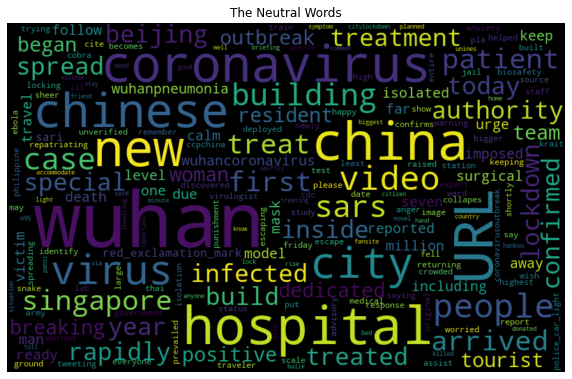

In [46]:
# Plotting WordCloud for Neutral sentiment
plt.figure(figsize=(10, 7))
plt.imshow(neutral_words, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

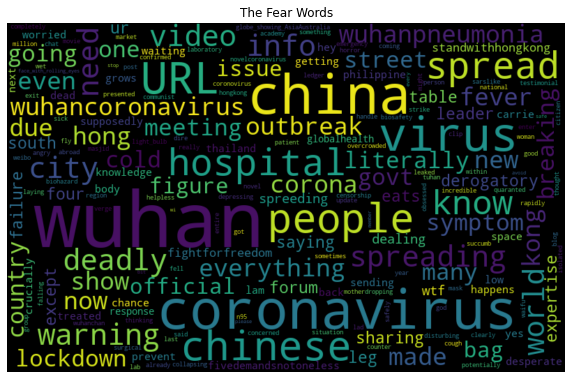

In [47]:
# Plotting WordCloud for Fear sentiment
plt.figure(figsize=(10, 7))
plt.imshow(fear_words, interpolation="bilinear")
plt.axis('off')
plt.title('The Fear Words')
plt.show()

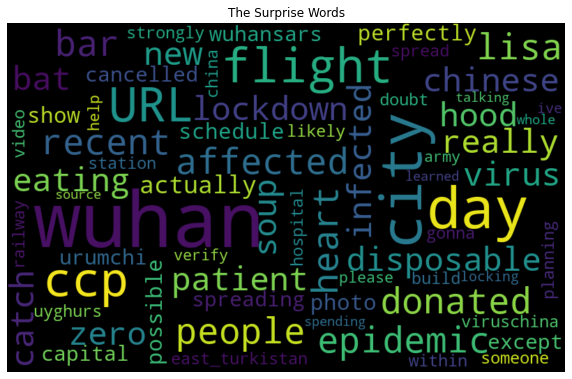

In [48]:
# Plotting WordCloud for Surprise sentiment
plt.figure(figsize=(10, 7))
plt.imshow(surprise_words, interpolation="bilinear")
plt.axis('off')
plt.title('The Surprise Words')
plt.show()

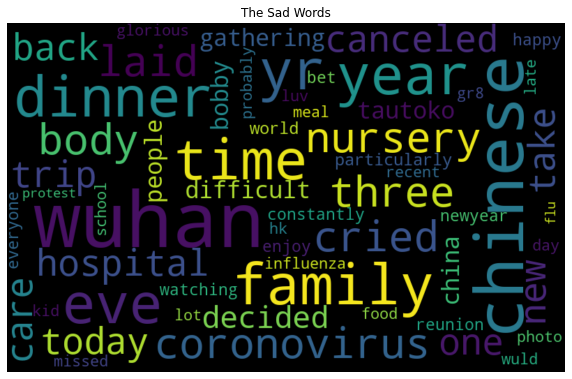

In [49]:
# Plotting WordCloud for Sad sentiment
plt.figure(figsize=(10, 7))
plt.imshow(sadness_words, interpolation="bilinear")
plt.axis('off')
plt.title('The Sad Words')
plt.show()

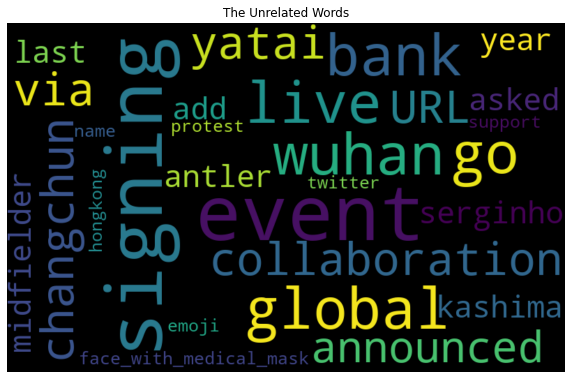

In [50]:
# Plotting WordCloud for Unrelated sentiment
plt.figure(figsize=(10, 7))
plt.imshow(unrelated_words, interpolation="bilinear")
plt.axis('off')
plt.title('The Unrelated Words')
plt.show()

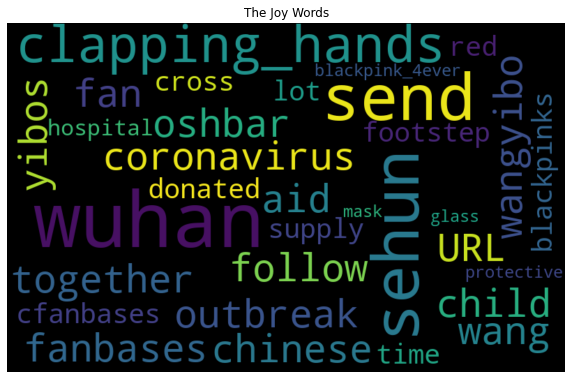

In [51]:
# Plotting WordCloud for Joy sentiment
plt.figure(figsize=(10, 7))
plt.imshow(joy_words, interpolation="bilinear")
plt.axis('off')
plt.title('The Joy Words')
plt.show()

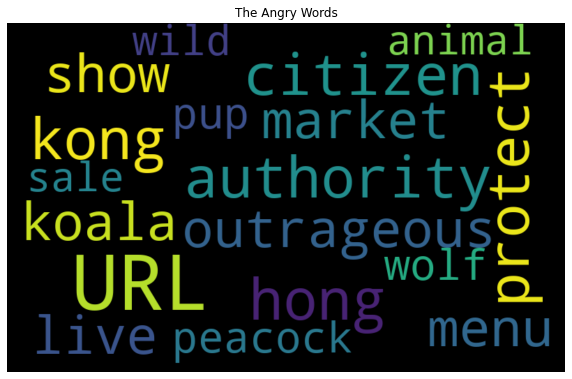

In [52]:
# Plotting WordCloud for Angry sentiment
plt.figure(figsize=(10, 7))
plt.imshow(anger_words, interpolation="bilinear")
plt.axis('off')
plt.title('The Angry Words')
plt.show()

**All feature visualization**

In [53]:
feature_data.head()

,processed_tweet,sentiment,full_text,capital_char_count,capital_word_count,sentences_count,unique_words_count,mentions_count,url_count,char_count,word_count,average_wordlength,average_sentence_length,sentiment_encoded
0,derogatory saying chinese eats everything four...,Fear,RT @PravitR: There’s​ a derogatory saying that...,0.074468,0.047619,0.166667,0.439024,0.333333,0.0,0.377990,0.354839,0.354064,0.261905,1
1,report chinese army pla deployed wuhan assist ...,Neutral,RT @ConflictsW: Reports that the Chinese Army ...,0.117021,0.095238,0.000000,0.439024,0.333333,0.0,0.296651,0.290323,0.304965,0.476190,3
2,authority protect citizen like hong kong URL,Anger,RT @lokinhei: that is how authorities protect ...,0.042553,0.047619,0.333333,0.268293,0.333333,1.0,0.167464,0.161290,0.278622,0.063492,0
3,u sharing ur expertise failure leader forum r ...,Fear,Are u sharing ur expertise of what a failure l...,0.265957,0.047619,0.500000,0.804878,0.000000,1.0,0.861244,0.774194,0.432079,0.261905,1
4,philippine sending chinese back wuhan prevent ...,Fear,RT @Woppa1Woppa: Philippines is sending the Ch...,0.074468,0.047619,0.166667,0.414634,0.333333,0.0,0.349282,0.290323,0.460993,0.214286,1


In [54]:
# Boxplot with dropdown menu for main features:

fig = go.Figure()

# Add Traces

fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['sentences_count']))  
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['unique_words_count']))  
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['mentions_count'])) 
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['url_count']))  
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['char_count']))  
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['word_count']))  
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['average_wordlength']))  
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['average_sentence_length']))
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['capital_char_count']))
fig.add_trace(go.Bar(x=feature_data['sentiment'], y=feature_data['capital_word_count']))  

# Add Buttons

fig.update_layout(
    updatemenus=[
        dict(
            active=1,
            buttons=list([ 
                
                dict(label='Sentences',
                     method='update',
                     args=[{'visible': [True, False, False, False, False, False, False, False, False, False]},
                           {'title': 'Bar plot for Sentences count'}]),
                          
                dict(label='Unique Words',
                     method='update',
                     args=[{'visible': [False, True, False, False, False, False, False, False, False, False]},
                           {'title': 'Bar plot for Unique words count'}]),
                          
                dict(label='Mention Words',
                     method='update',
                     args=[{'visible': [False, False, True, False, False, False, False, False, False, False]},
                           {'title': 'Bar plot for mention words count'}]),

                dict(label='URL',
                     method='update',
                     args=[{'visible': [False, False, False, True, False, False, False, False, False, False]},
                           {'title': 'Bar plot for URL count'}]),                

                dict(label='Characters',
                     method='update',
                     args=[{'visible': [False, False, False, False, True, False, False, False, False, False]},
                           {'title': 'Bar plot for characters count'}]),               

                dict(label='Words',
                     method='update',
                     args=[{'visible': [False, False, False, False, False, True, False, False, False, False]},
                           {'title': 'Bar plot for words count'}]),

                dict(label='Average Words',
                     method='update',
                     args=[{'visible': [False, False, False, False, False, False, True, False, False, False]},
                           {'title': 'Bar plot for average word length'}]),

                dict(label='Average Sentences',
                     method='update',
                     args=[{'visible': [False, False, False, False, False, False, False, True, False, False]},
                           {'title': 'Bar plot for average sentence length'}]),
                          
                dict(label='Capital Characters',
                     method='update',
                     args=[{'visible': [False, False, False, False, False, False, False, False, True, False]},
                           {'title': 'Bar plot for Capital character count'}]),

                dict(label='Capital Words',
                     method='update',
                     args=[{'visible': [False, False, False, False, False, False, False, False, False, True]},
                           {'title': 'Bar plot for Capital character count'}]),                                                    
            ]),
        )
    ])

# Set title
fig.update_layout(title_text='Feature Bar plot', template='plotly_dark', width=900, height=500)

fig.show()

# **Word Embedding**

**Tokenization**

In [55]:
# converting sentences into tokens
tokenized_tweet = feature_data['processed_tweet'].apply(lambda x: x.split()) 

**Word2Vec Model and training**

In [56]:
# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=100, # desired no. of features/independent variables 
            window=7, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            seed = 34,)

model_w2v.train(tokenized_tweet, total_examples= len(feature_data['processed_tweet']), epochs=20)


(7625, 23700)

In [57]:
# Saving the model
model_w2v.save("word2vec_model")

In [58]:
# Checking the model for accuracy
model_w2v.wv.most_similar(positive = "virus")

[('coronavirus', 0.9983711838722229),
 ('china', 0.9982966780662537),
 ('wuhan', 0.9982253909111023),
 ('home', 0.9981546401977539),
 ('patient', 0.9981432557106018),
 ('many', 0.9981337189674377),
 ('happy', 0.9980645775794983),
 ('chinese', 0.9979959726333618),
 ('symptom', 0.9979840517044067),
 ('spread', 0.9979318976402283)]

**Preparing Vectors for Tweets**

In [59]:
# Method to convert words to vectors using custom trained model
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [60]:
# Converting words to vectors. Output : dataframe with vectors
wordvec_arrays = np.zeros((len(tokenized_tweet), 100))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 100)
wordvec_data = pd.DataFrame(wordvec_arrays)

In [61]:
# Excluding columns of less important
final_data = combining_dataset(wordvec_data, feature_data)
final_data = final_data.drop(['full_text', 'sentiment','processed_tweet'], axis = 1)

# **Splitting data into training and testing**

In [62]:
# Getting X and y Values from dataset
copy_final_data = final_data

y = final_data['sentiment_encoded'].values
final_data = final_data.drop(['sentiment_encoded'], axis = 1)
X = np.array(final_data)

In [63]:
# Oversampling of data
over = RandomOverSampler(sampling_strategy='auto')
X, y = over.fit_resample(X, y)

# Undersampling of data
under = RandomUnderSampler(sampling_strategy='auto')
X, y = under.fit_resample(X, y)


# summarize class distribution
print(Counter(y))

Counter({0: 48, 1: 48, 2: 48, 3: 48, 4: 48, 5: 48, 6: 48})


In [64]:
# Splitting the data into trainig and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# **Modeling**

In [65]:
# Stacking of ML Models
eclf = VotingClassifier(estimators=[ 
    ('SVM', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('rf', ensemble.RandomForestClassifier()),
    ('bayes',GaussianNB()),
    ('logistic',LogisticRegression()),
    ], voting='soft')

In [66]:
# Hyperparameter Tuning using gridSearch
params = {'SVM__C':[0.2, 0.5, 1],
          'SVM__gamma':[0.1, 0.01],
          'knn__n_neighbors': [1,3,5],
          'rf__n_estimators':[100, 800],
          }

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
voting_clf = grid.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)

In [67]:
# Displaying the model accuracy
print(f"Voting Classifier's accuracy: {accuracy_score(y_pred, y_test):.2f}")
print(voting_clf.best_params_)

Voting Classifier's accuracy: 0.85
{'SVM__C': 0.2, 'SVM__gamma': 0.01, 'knn__n_neighbors': 1, 'rf__n_estimators': 800}


# **Result Visualization**

In [68]:
# Analysing predicted result
pred_result = classification_report(y_test, y_pred)
print(pred_result)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      0.38      0.53        13
           2       1.00      1.00      1.00         9
           3       0.64      0.78      0.70         9
           4       1.00      1.00      1.00         7
           5       0.69      1.00      0.82         9
           6       0.92      1.00      0.96        11

    accuracy                           0.85        68
   macro avg       0.87      0.88      0.86        68
weighted avg       0.87      0.85      0.84        68



In [69]:
# Predicting y_test using the model
y_pred = voting_clf.predict(X_test)

# Y_test data
print("Original traget label for x_test")
print(y_test)

# Y_test data
print(" Predicted traget label for x_test")
print(y_pred)

Original traget label for x_test
[1 2 6 2 5 0 4 5 6 2 4 0 0 1 1 4 3 3 2 1 5 2 1 6 1 0 2 5 4 2 0 5 6 0 3 4 3
 5 1 6 1 0 3 4 2 5 6 1 3 0 2 6 3 3 5 1 0 3 6 0 1 1 4 6 6 6 1 5]
 Predicted traget label for x_test
[5 2 6 2 5 0 4 5 6 2 4 0 0 1 3 4 3 3 2 1 5 2 5 6 1 0 2 5 4 2 0 5 6 0 1 4 3
 5 3 6 6 0 3 4 2 5 6 3 3 0 2 6 5 3 5 3 0 3 6 0 1 5 4 6 6 6 1 5]


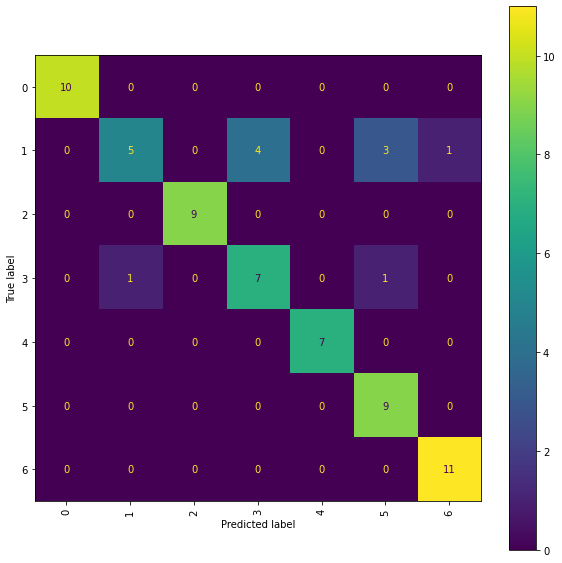

In [70]:
# confusion matrix to analyse the result.
con_matrix = confusion_matrix(y_test, y_pred, labels=voting_clf.classes_)
figure, axes = plt.subplots(1, figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix, display_labels=voting_clf.classes_)
disp.plot(ax = axes, xticks_rotation='vertical')

# **Sanity Example:**

In [81]:
tweet_test = "RT @badiucao: Likely a video from #Wuhan railway station."

feature_data_test = feature_extraction(tweet_test)
feature_data_test = pd.DataFrame(feature_data_test, columns=['capital_char_count', 'capital_word_count', 'full_text','sentences_count', 'unique_words_count', 'mentions_count', 'url_count', 'processed_tweet', 'char_count', 'word_count', 'average_wordlength', 'average_sentence_length'])

feature_data_test.drop(columns=['full_text'],inplace=True)
feature_data_test.drop(columns=['processed_tweet'],inplace=True)

scaled_tweet = scaler.transform(feature_data_test.values)
feature_data_test = pd.DataFrame(scaled_tweet, columns=['capital_char_count', 'capital_word_count', 'sentences_count', 'unique_words_count', 'mentions_count', 'url_count', 'char_count', 'word_count', 'average_wordlength', 'average_sentence_length'])

tokenized_input = tweet_preprocessing(tweet_test).split()

wordvec_arrays = np.zeros((len(tokenized_input), 100))
wordvec_arrays = word_vector(tokenized_input, 100)

wordvec_data_test = pd.DataFrame(wordvec_arrays)

test_data = combining_dataset(wordvec_data_test, feature_data_test)
test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,capital_char_count,capital_word_count,sentences_count,unique_words_count,mentions_count,url_count,char_count,word_count,average_wordlength,average_sentence_length
0,0.045275,-0.078725,-0.021927,0.01432,-0.110368,0.009278,0.063185,-0.129064,0.072575,0.035872,-0.06192,0.032124,-0.096517,0.014488,-0.024388,0.072744,-0.053678,-0.169922,-0.116645,-0.049692,-0.28422,0.186812,-0.137804,0.05339,-0.177181,-0.025542,-0.21625,-0.068959,0.157923,0.001002,-0.034636,-0.171592,-0.123259,0.106786,-0.058911,-0.244491,0.032368,0.059188,0.076629,-0.029308,...,0.132952,-0.032334,0.006097,0.108078,0.122417,-0.116083,-0.095412,-0.104059,-0.061344,-0.053212,-0.043634,0.010917,-0.07637,0.20424,0.057751,0.193381,-0.176926,-0.086698,0.175942,0.192384,0.060234,0.004779,0.219856,-0.081968,0.145158,-0.019433,-0.151524,-0.08014,0.120632,0.086726,0.010638,0.047619,0.0,0.121951,0.333333,0.0,0.119617,0.096774,0.358865,0.190476


In [82]:
y_pred = voting_clf.predict(np.array(test_data))
print(y_pred)

target = sentiment_label_encoder.inverse_transform(y_pred)
print(target)

[5]
['Surprise']
